In [1]:
import os
import random
import sys
import platform
import cv2

import pandas as pd
from sklearn.impute import SimpleImputer

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
import seaborn as sns
from scipy.spatial.distance import euclidean

def check_os():
    os = platform.system()

    if os == 'Darwin':
        return "MacOS"
    elif os == 'Linux':
        return "Linux"
    else:
        return "Unknown OS"

In [2]:
operating_system = check_os()

if operating_system == "MacOS":
    root_path = "/Users/johnny/Projects/"
elif operating_system == "Linux":
    root_path = "/home/johnny/Projects/"

In [3]:
def parse_annotation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        elements = line.split()
        id_ = elements[0]
        class_ = elements[1]
        x = int(elements[2])
        y = int(elements[3])
        width = int(elements[4])
        height = int(elements[5])
        occlusion = int(elements[6])
        loitering = int(elements[7])

        data.append([id_, class_, x, y, width, height, occlusion, loitering])

    return data

In [4]:
if not os.path.exists(root_path + "/Master_Thesis_CV/datasets/annotations.csv"):

    # Raíz de la carpeta de datos

    root_folder = os.path.join(root_path, "datasets/harbor-synthetic/annotations/")

    # Crear un dataframe vacío para almacenar todos los datos
    df = pd.DataFrame(columns=['id', 'class', 'x', 'y', 'width', 'height', 'occlusion', 'loitering'])
    # Crear una lista vacía para almacenar todos los dataframes
    dfs = []
    # Recorrer todas las carpetas y subcarpetas
    for folder, subfolders, files in tqdm(os.walk(root_folder)):
        # example '/Users/johnny/Projects/datasets/harbor-synthetic/annotations/20210220/clip_6_0248'
        temp_split = folder.split('/')
        clip_name = temp_split[-1]
        folder_name = temp_split[-2]
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(folder, file)
                data = parse_annotation_file(file_path)
                # frame_name = file.split('.')[0]
                frame_name = file.split('_')[-1].split('.')[0]
                # Añadir el nombre de la carpeta y el clip a cada fila
                for row in data:
                    row.insert(0, frame_name)
                    row.insert(0, clip_name)
                    row.insert(0, folder_name)
                    
                # Añadir los datos a la lista de dataframes
                dfs.append(
                    pd.DataFrame(data,
                                 columns=['folder', 'clip', "frame", 'id', 'class', 'x', 'y', 'width', 'height', 'occlusion', 'loitering']))

    # Concatenar todos los dataframes
    df = pd.concat(dfs, ignore_index=True)

    # guardar el dataframe en un archivo csv
    # path actual de la carpeta
    path_actual = os.getcwd()

    df.to_csv(root_path + "Master_Thesis_CV/datasets/" + "annotations.csv", index=False)

In [5]:
df = pd.read_csv(root_path + "/Master_Thesis_CV/datasets/annotations.csv").sort_values(by=['id', 'frame'])

In [6]:
df.fillna(0, inplace=True)

In [7]:
MATRIX_PATH = root_path + '/Master_Thesis_CV/datasets/perspective_matrix.txt'

def transform_points(pts1):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')
    pts2 = cv2.perspectiveTransform(pts1, M)
    return pts2


def transform_df_points(df):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')

    df_pts = df[['x', 'y']]
    pts1 = df_pts.to_numpy(dtype=np.float32)
    pts1 = np.expand_dims(pts1, axis=0)

    pts2 = cv2.perspectiveTransform(pts1, M)
    df['x_transform'] = pts2[0, :, 0]
    df['y_transform'] = pts2[0, :, 1]
    return df

In [8]:
df = transform_df_points(df)

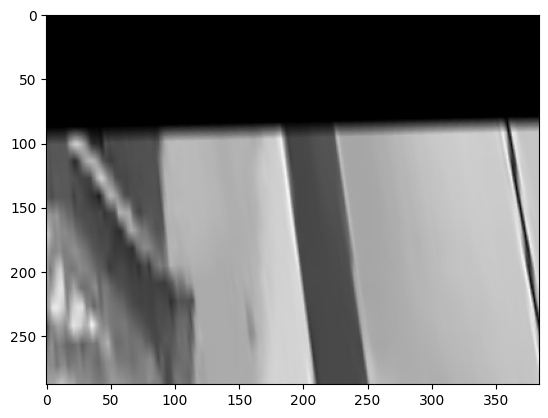

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def transform_image(image):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')
    dst = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
    return dst

image_path = root_path + 'datasets/harbor-synthetic/LTD_Dataset/LTD_Dataset/Image_Dataset_25fps/20200514/clip_0_1331/image_0000.jpg'
image = cv2.imread(image_path)
perspective_matrix = np.array([[-9.630453, 3.506296, 88.109627],
                               [0.042233, 44.804132, -13209.190834],
                               [-0.002061, -0.014562, 1.000000]])

# Apply the perspective transformation
output_image = cv2.warpPerspective(image, perspective_matrix, (image.shape[1], image.shape[0]))
plt.imshow(output_image)



In [9]:
df = df[df['class'] == 'human']
df

,folder,clip,frame,id,class,x,y,width,height,occlusion,loitering
37,20200514,clip_0_1331,49,3,human,108,95,113,111,1,0
38,20200514,clip_0_1331,50,3,human,109,96,114,112,0,0
39,20200514,clip_0_1331,51,3,human,110,96,115,113,1,0
40,20200514,clip_0_1331,52,3,human,111,96,116,113,0,0
41,20200514,clip_0_1331,53,3,human,112,96,118,113,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7226786,20210312,clip_9_0412,113,150355,human,167,109,175,130,1,0
7226787,20210312,clip_9_0412,114,150355,human,171,108,175,129,1,0
7226788,20210312,clip_9_0412,115,150355,human,175,110,179,130,1,0
7226789,20210312,clip_9_0412,118,150355,human,189,114,193,133,1,0


In [10]:
# filter by folder
list_folders_visualized = [20200514, 20200515, 20200516, 20200517, 20200519, 20200520, 20200521, 20200522, 20200523, 20200524, 20200525]
df_filtered = df[df['folder'].isin(list_folders_visualized)]

In [11]:
df_filtered

,folder,clip,frame,id,class,x,y,width,height,occlusion,loitering
37,20200514,clip_0_1331,49,3,human,108,95,113,111,1,0
38,20200514,clip_0_1331,50,3,human,109,96,114,112,0,0
39,20200514,clip_0_1331,51,3,human,110,96,115,113,1,0
40,20200514,clip_0_1331,52,3,human,111,96,116,113,0,0
41,20200514,clip_0_1331,53,3,human,112,96,118,113,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6936901,20200517,clip_7_0320,88,144230,human,58,70,62,75,0,0
6936902,20200517,clip_7_0320,89,144230,human,58,70,62,75,0,0
6936903,20200517,clip_7_0320,90,144230,human,58,70,62,75,0,0
6936904,20200517,clip_7_0320,91,144230,human,58,70,62,75,0,0


In [12]:
# ids = pd.read_excel(root_path + "/Master_Thesis_CV/datasets/ID_2.xlsx")

In [13]:
ids = pd.read_csv(root_path + "/Master_Thesis_CV/datasets/ID.csv")

In [14]:
ids

,id
0,9
1,149
2,153
3,186
4,195
...,...
1015,4438
1016,4439
1017,4440
1018,4457


In [15]:
# Unnamed: 0 to list
list_ids = ids['id'].tolist()
# string to integer
list_ids = [int(i) for i in list_ids]

In [16]:
df_filtered['loitering'] = df.apply(lambda row: 1 if row['id'] in list_ids else row['loitering'], axis=1)


/var/folders/zx/jf3y79md34qbbnjhs1tkgmhw0000gn/T/ipykernel_1310/886599330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['loitering'] = df.apply(lambda row: 1 if row['id'] in list_ids else row['loitering'], axis=1)


In [17]:
df_filtered.to_csv(root_path + "/Master_Thesis_CV/datasets/annotations_filtered.csv", index=False)

In [18]:
# count unique ids that are loitering == 1 and loitering == 0,
# df_filtered['loitering'].value_counts()  it is by frame, i must group by id
loitering_counts = df_filtered[df_filtered['loitering'] == 1]
loitering_counts_2 = df_filtered[df_filtered['loitering'] == 0]
len(loitering_counts_2)



224597

In [19]:
# Calculate the percentage of unique IDs for loitering
total_unique_ids = 922 + 5979
percentage_loitering_ids = (922 / total_unique_ids) * 100

# Calculate the percentage of unique IDs for not loitering
percentage_not_loitering_ids = (5979 / total_unique_ids) * 100

# Calculate the percentage of frames for loitering
total_frames = 79153 + 224597
percentage_loitering_frames = (79153 / total_frames) * 100

# Calculate the percentage of frames for not loitering
percentage_not_loitering_frames = (224597 / total_frames) * 100

print("Percentage of unique IDs for loitering:", percentage_loitering_ids)
print("Percentage of unique IDs for not loitering:", percentage_not_loitering_ids)
print("Percentage of frames for loitering:", percentage_loitering_frames)
print("Percentage of frames for not loitering:", percentage_not_loitering_frames)


Percentage of unique IDs for loitering: 13.360382553253153
Percentage of unique IDs for not loitering: 86.63961744674685
Percentage of frames for loitering: 26.058600823045268
Percentage of frames for not loitering: 73.94139917695473


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the dataset
df = pd.read_csv(root_path + "/Master_Thesis_CV/datasets/annotations_filtered.csv")

# Get unique IDs
unique_ids = df['id'].unique()

# Split IDs into train, validation, and test sets
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

# Split the dataset based on ID
train_data = df[df['id'].isin(train_ids)]
val_data = df[df['id'].isin(val_ids)]
test_data = df[df['id'].isin(test_ids)]


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Paso 1: Leer los datos del archivo CSV
data = pd.read_csv(root_path + "/Master_Thesis_CV/datasets/annotations_filtered.csv")

# Paso 2: Obtener los IDs únicos
unique_ids = data['id'].unique()

# Paso 3: Dividir los IDs en conjunto de entrenamiento y conjunto de prueba
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42, stratify=data.groupby('id')['loitering'].max())

# Paso 4: Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_data = data[data['id'].isin(train_ids)]
test_data = data[data['id'].isin(test_ids)]

# Paso 5: Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42, stratify=train_data.groupby('id')['loitering'].max())
train_data = data[data['id'].isin(train_ids)]
val_data = data[data['id'].isin(val_ids)]

# Paso 6: Guardar los conjuntos de datos en archivos CSV separados
train_data.to_csv('train.csv', index=False)
val_data.to_csv('validation.csv', index=False)
test_data.to_csv('test.csv', index=False)


In [22]:
train_data

,folder,clip,frame,id,class,x,y,width,height,occlusion,loitering
70,20200514,clip_0_1331,49,4,human,113,96,118,112,1,0
71,20200514,clip_0_1331,50,4,human,114,96,119,112,0,0
72,20200514,clip_0_1331,51,4,human,115,96,120,113,1,0
73,20200514,clip_0_1331,52,4,human,116,96,120,113,1,0
74,20200514,clip_0_1331,53,4,human,117,97,123,113,0,0
...,...,...,...,...,...,...,...,...,...,...,...
303684,20200517,clip_50_2315,115,144228,human,98,82,103,91,1,1
303685,20200517,clip_50_2315,116,144228,human,98,82,103,91,1,1
303686,20200517,clip_50_2315,117,144228,human,100,82,105,91,0,1
303687,20200517,clip_50_2315,118,144228,human,102,83,106,91,1,1


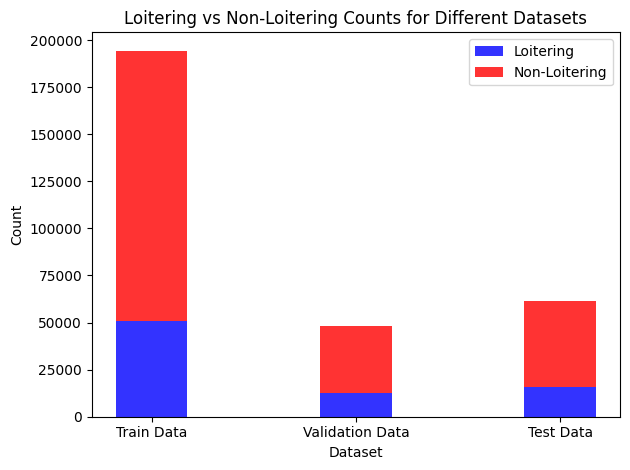

In [23]:
import matplotlib.pyplot as plt

# Calculate loitering and non-loitering counts for train_data
train_loitering_count = train_data['loitering'].sum()
train_non_loitering_count = len(train_data) - train_loitering_count

# Calculate loitering and non-loitering counts for val_data
val_loitering_count = val_data['loitering'].sum()
val_non_loitering_count = len(val_data) - val_loitering_count

# Calculate loitering and non-loitering counts for test_data
test_loitering_count = test_data['loitering'].sum()
test_non_loitering_count = len(test_data) - test_loitering_count

# Create a bar plot
categories = ['Train Data', 'Validation Data', 'Test Data']
loitering_counts = [train_loitering_count, val_loitering_count, test_loitering_count]
non_loitering_counts = [train_non_loitering_count, val_non_loitering_count, test_non_loitering_count]

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

index = range(len(categories))

rects1 = ax.bar(index, loitering_counts, bar_width,
                alpha=opacity, color='b', label='Loitering')

rects2 = ax.bar(index, non_loitering_counts, bar_width,
                alpha=opacity, color='r', label='Non-Loitering', bottom=loitering_counts)

ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Loitering vs Non-Loitering Counts for Different Datasets')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

fig.tight_layout()
plt.show()